<a href="https://colab.research.google.com/github/M-Sravanthi/PyTorchTutorial/blob/main/04_Pytorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Pytorch Custom Datasets Video Notebook
We've used some datasets with PyTorch before
But how do you get your own data into Pytorch ?
One of the ways to do is via: custom datasets.

## Domain Libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading fucntions and customizable data loading functions.


** Resources **
* Book version of the course materail for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


## 0. Importing PyTorch and setting device agnostic code



In [1]:
import torch
from torch import nn

# Note: Pytorch 1.10.0 + is required for this exercise
torch.__version__

'2.9.0+cu126'

In [2]:
# Setup device-agnostic device code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
#nvidia-smi

##1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why so ? When starting out ML projects, it's important to try things in a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment - only then extend it to the entire dataset.


In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

# If the image folder doesnt exists download

if image_path.is_dir():
  print('Already exists so skipping download')
else:
  print('Downloading data')
  image_path.mkdir(parents=True, exist_ok=True)
  # Download
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
    f.write(request.content)
  # Unzip the downloaded file

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip",'r') as zip_ref:
  print('Unzipping Pizza, steak and sushi data')
  zip_ref.extractall(image_path)


Unzipping Pizza, steak and sushi data


In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents."""

  for dirpath,dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [7]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image
Lets write some code
1. Get all the image paths
2. Pick a random image path using Python's random.choice():
3. Get the image class name using `pathlib.path.parent.stem`
4. Since we're working with images, opent the image using Python's `pillow` library (PIL)
5. Show the image and print the metadata.


Random image path: data/pizza_steak_sushi/test/steak/296375.jpg
Random image class: steak
Image heigth: 512
Image width: 382


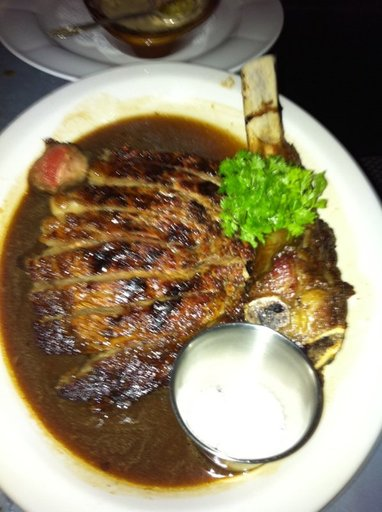

In [8]:
import random
import PIL
from PIL import Image

#Set the seed
#random.seed(42)

#1. Get all the imaage paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path
random_image_path = random.choice(image_path_list)

#3. Get image class name (image class is the name of the directory where the image is stored)
random_image_class = random_image_path.parent.stem

#4. Open image
img = Image.open(random_image_path)

#5. Print the metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class}")
print(f"Image heigth: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(381.5), np.float64(511.5), np.float64(-0.5))

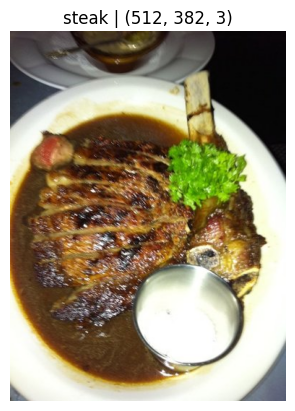

In [9]:
# Try to visualize with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)


plt.imshow(img_as_array)
plt.title(f"{random_image_class} | {img_as_array.shape}") # shape format is in height, width, colour channels
plt.axis(False)



## 3. Transforming the data into tensor
Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. First transform it into a tensor using `torchvision.ToTensor`
3. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we ll call these Dataset and DataLoader


##3.1 Transforming data with `torchviosion.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://docs.pytorch.org/vision/0.9/transforms.html


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Write a transform for image

data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size =(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor()
    ])


In [12]:
data_transform(img).dtype,data_transform(img).shape

(torch.float32, torch.Size([3, 64, 64]))

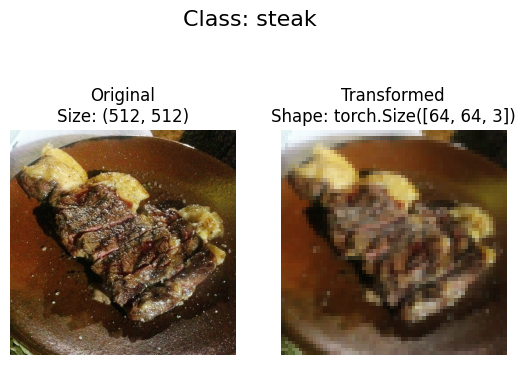

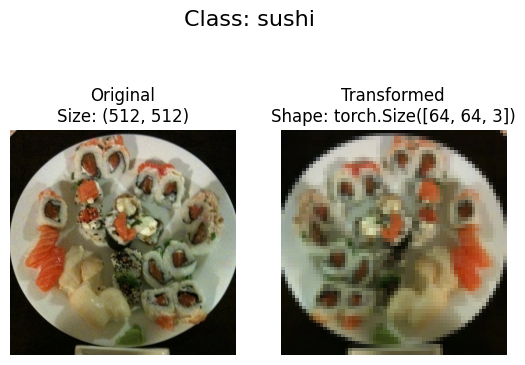

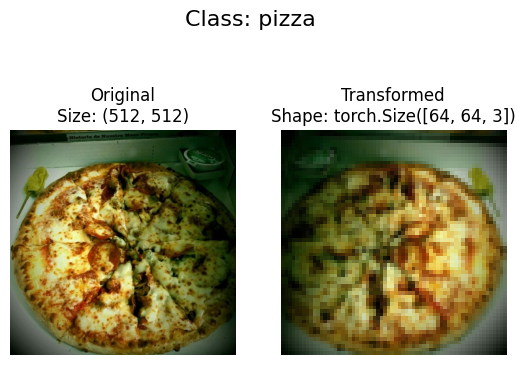

In [13]:
def plot_transformed_images(image_paths,transform, n=3, seed = 42):
  """
  Selects random images from a path of images and loads/transforms them and then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform and plot the target image
      transformed_image = transform(f).permute(1,2,0) # changing the order from C H W -> H W C -- this is the right format for matplot lib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize =16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed =None)


## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html


In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=data_transform,  # a transform for the data
                                  target_transform = None # a transform for the target/label
                                  )

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform,
                                 )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_to_idx = train_data.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of the datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
# Targets/labels of the data
train_data.targets[70:90]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [19]:
class_names[0]

'pizza'

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
# Index on the train_data datasets to get a single image and label
img,label = train_data[0]


#Another way to do the same thing
#img2, label2 = train_data[0][0],train_data[0][1]
#img1.shape,label1,img2.shape,label2
print(f"Image Tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image lable: {label}")
print(f"Label datatype: {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color channel, ht,width]
Permuted Image: torch.Size([64, 64, 3]) -> [ht,width, color channel]


Text(0.5, 1.0, 'pizza')

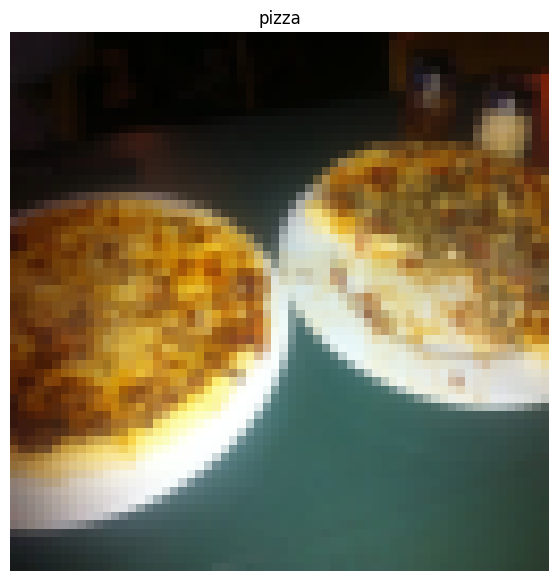

In [22]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color channel, ht,width]")
print(f"Permuted Image: {img_permute.shape} -> [ht,width, color channel]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label])

### 4.1  Turn loaded images into DataLoaders
 A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customise the batch_size so our model can see `batch_size` images at a time.

In [23]:
import os
os.cpu_count()

2

In [24]:
# Turning the the data into dataloader
from torch.utils.data import DataLoader


train_dataloader = DataLoader(
                              batch_size = 1,
                              shuffle = True,
                              dataset = train_data,
                              num_workers=1)

test_dataloader = DataLoader(
                          dataset = test_data,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bb49b1877d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bb49b2c42c0>)

In [25]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
img.shape, label

(torch.Size([1, 3, 64, 64]), tensor([0]))

## 5 Option 2: Loading Image Data with a Custom `Dataset`
If our data was not inherently in a compatible format such that `ImageFolder` function from `torchvision` is not able to read and format it as required into train and test and class names and class_to_idx - then how do we customize the data

1. Want to be able to load images from file
2. Want to be able to get class-names from dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesnt always mean it will work....
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass -

In [27]:
import os
from pathlib import Path
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List #so we can put type hints when create our class and loading functions

In [28]:
# Instance of torchvision.datasets.ImageFolder()
# We want this functionality when we create our custime datasetse
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to :
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in std image classfication format).
2. Raise an error if the class names arent found (if this happens, there might be something wrong with the dir structure)
3. Turn the class names into a dict and a list and return them



In [29]:
# Set up path for target directory
target_directory = train_dir
target_directory #this should be the place to begin when we are customizing the dataset
# data should already be in train and test directories with one folder for each class (eg 3 folders in this case - pize, sushi, steak)

print(f"Target dir: {target_directory}")

#Get the class names from the target directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory:str)-> Tuple[List[str], Dict[str,int]]:
  """
  Finds the class folder names in a target directory.
  Takes in a directory which is a string and returns a tuple of list of class names(strings) and a dictionary of class_names(strings) mapped to index (integers).
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

  #2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in the {directory}.. Please check file structure")

  #3. Create a dictionary of index lables (computers prefer number rather than strins as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes,class_to_idx
find_classes(target_directory)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Sublass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * Paths - paths of our images
  * Transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
                                      
4. Create a function to `load_images()`this function will open an image
5. Overwrite the `__len()__ `method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [31]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset
from pathlib import Path
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialise our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform= transform
    #Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int)->Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self,index:int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label(X,y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx #return data, label (X,y)
    else:
      return img, class_idx # return untransformed image and label


In [32]:
# Create a transform
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [33]:
# Test out ImageFolderCustom
from pathlib import Path
import pathlib
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform = train_transform)

test_data_custom = ImageFolderCustom(targ_dir= test_dir,
                                     transform=test_transform)


In [34]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7bb49b005a00>,
 <__main__.ImageFolderCustom at 0x7bb49b3df4a0>)

In [35]:
len(train_data),len(train_data_custom)

(225, 225)

In [36]:
len(test_data),len(test_data_custom)

(75, 75)

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

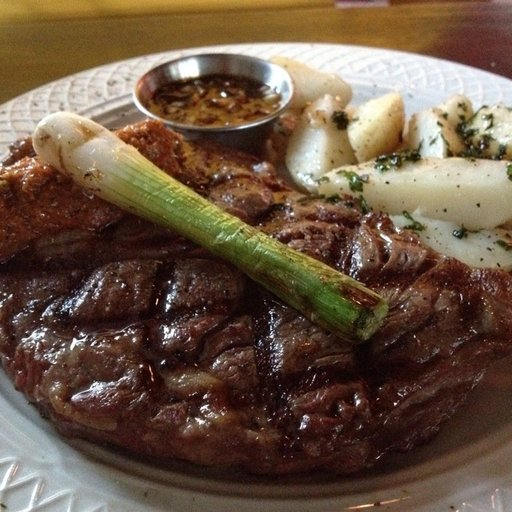

In [39]:
img = train_data_custom.load_image(10)
img

In [40]:
# Check for equality between original ImageFolder dataset and ImageFolderCustomDataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images from ImageFolderCustomDataset

1. Take in a `Dataset` and a number of other params such as class names and how many images to visualize.
2. Lets cap the no. of images to display at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Set up a matplotlib plot_transformed_images
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [41]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int =10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n>10:
    n=10
    display_shape = False
    print(f"For display purposes, n is capped at 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random dsample indexes
  random_sample_idx = random.sample(range(len(dataset)),k=n)

  # 5. Set up plot
  plt.figure(figsize = (16,8))

  # 6. Loop thru random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dim to HCW
    targ_img_permute = targ_image.permute(1,2,0) #[CHW] -> [HCW]

    #plot permuted samples
    plt.subplot(3,4,i+1)
    plt.imshow(targ_img_permute)
    plt.axis("off")
    if classes:
      title =f"Class: {classes[targ_label]}"
      if display_shape:
        title = title+f"\nshape: {targ_img_permute.shape}"
    plt.title(title)

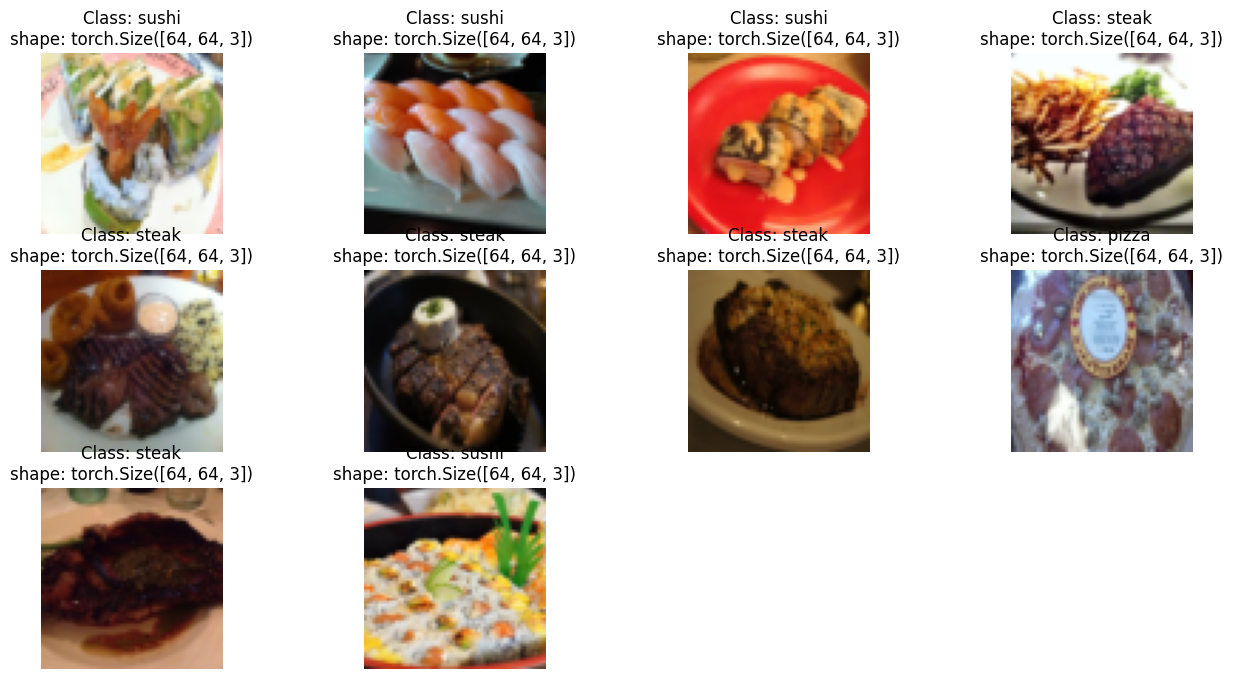

In [42]:
display_random_images(dataset= train_data_custom,
                      classes=train_data_custom.classes,
                      seed=None,
                      n= 10)

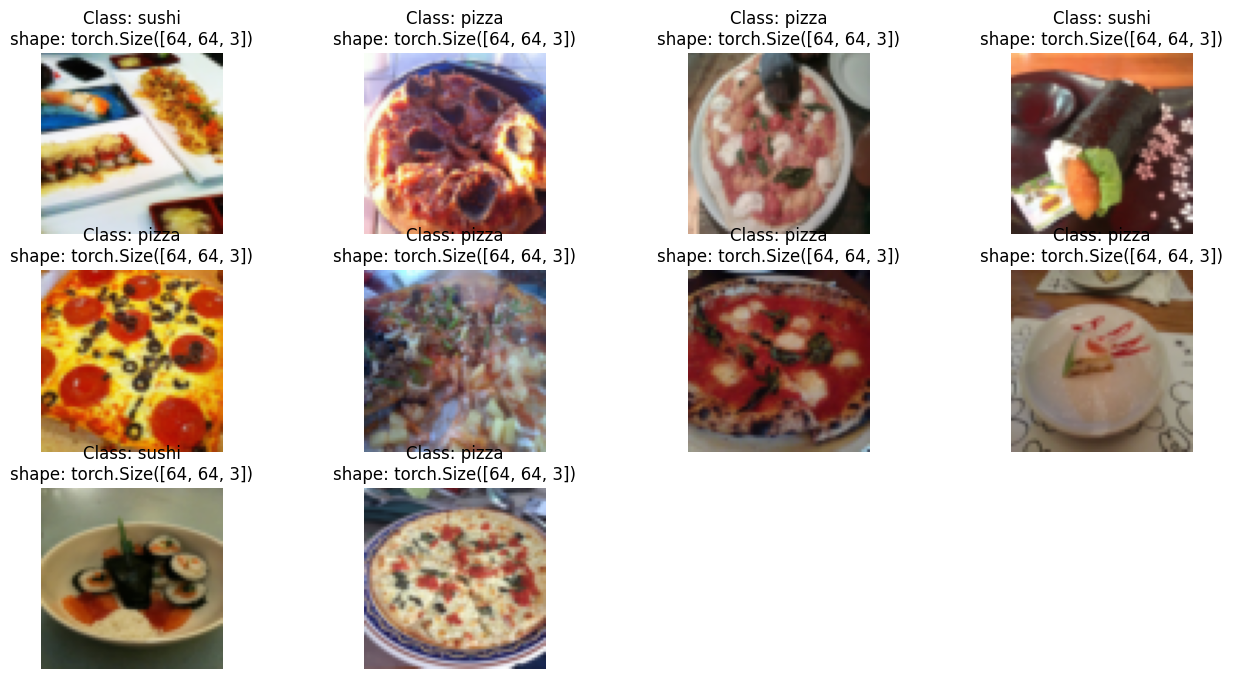

In [43]:
display_random_images(dataset= train_data,
                      classes=train_data.classes,
                      display_shape=True,
                      seed=42,
                      n= 10)

### 5.4 Turning the custom loaded images into dataloader

In [44]:
from torch.utils.data import DataLoader


train_custom_dataloader = DataLoader(
                              batch_size = 32,
                              shuffle = True,
                              dataset = train_data_custom,
                              num_workers=0)

test_custom_dataloader = DataLoader(
                          dataset = test_data_custom,
                          batch_size=32,
                          shuffle=False,
                          num_workers=0)

len(train_custom_dataloader), len(test_custom_dataloader)

(8, 3)

## 6. Other form of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data

In the case of image data, this may mean applying various image transformations to the training images.

Let's take a look at:
Particular data augmentation techniques used to train PyTorch visoin model to state of the art levels.. it makes the model more generalizable which is more capable of handling unseen data - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [45]:
# Lets look at trivial augment
# https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#trivialaugmentwide

from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
# Read the latest developments in arXiv


In [46]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/256592.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2254705.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2222018.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1736968.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/735441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2129685.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1647351.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2087958.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1961025.jpg')]

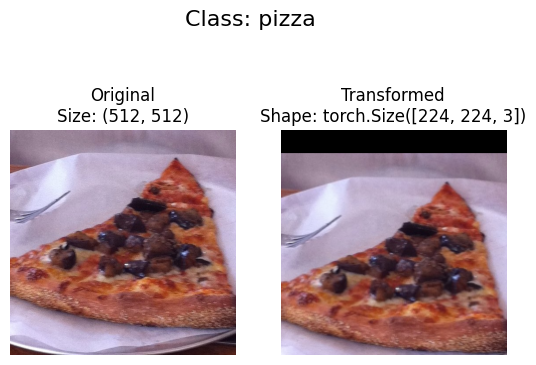

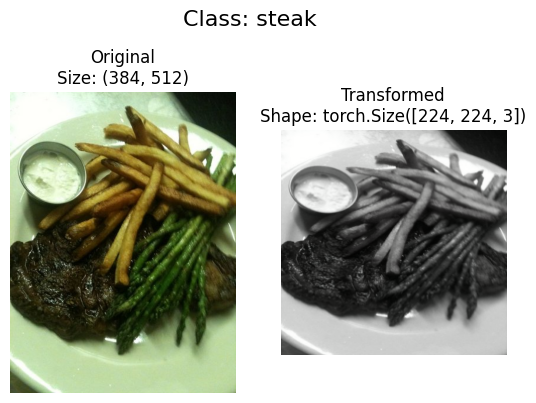

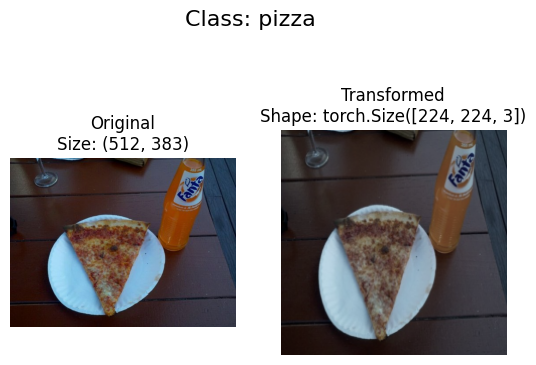

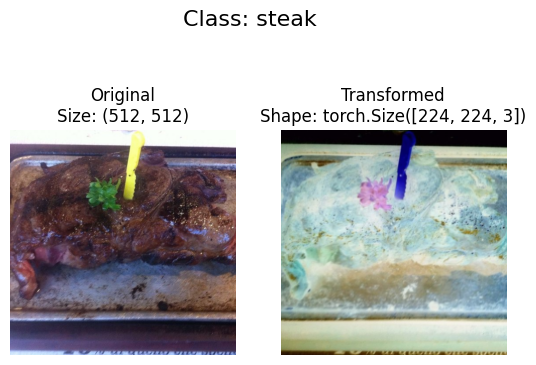

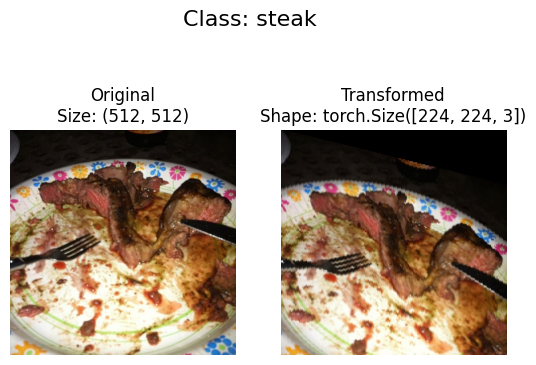

In [47]:
# Plot random transformed image
plot_transformed_images(image_paths = image_path_list,
                        n =5,
                        seed = None,
                        transform = train_transform)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website:

### 7.1 Creating transforms and loading data for Model 0

In [48]:
# Create simple transform

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [49]:
# 1. Load and transform data
from torch.utils.data import Dataset
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = 32,
                                     shuffle = True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size = 32,
                                     shuffle = False,
                                     num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG mmodel class

In [50]:
class TinyVGGModel0(nn.Module):
  def __init__(self,
                input_shape: int,
                output_shape: int,
                hidden_units = int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels =input_shape,
                  out_channels= hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels =hidden_units,
                  out_channels= hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0,
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels =hidden_units,
                  out_channels= hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels =hidden_units,
                  out_channels= hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(f"Shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Shape of classifier: {x.shape}")
    return x

In [51]:
torch.manual_seed(42)
model_0 = TinyVGGModel0(input_shape=3,
                        output_shape=len(class_names),
                        hidden_units = 10).to(device)
model_0

TinyVGGModel0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image( to test the model)

In [52]:
img_batch, label_batch = next(iter(train_dataloader_simple))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
model_0(img_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get info on the shapes going thru our model

In [54]:

!pip install torchinfo

In [55]:
import torchinfo
from torchinfo import summary

model_0_summary = summary(model_0,input_size=(1,3,64,64))
model_0_summary

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModel0                            [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test steps


In [56]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               #accuracy_fn: accuracy_fn,
               device: torch.device = device):
  # Put the model in training mode
  model.train()

  #Set up train loss and train_acc values
  train_loss = 0; train_acc = 0

  # Loop through dataloader data batches
  for batch, (X,y) in enumerate(dataloader):
    # 1. Put the data on target device
    X,y = X.to(device), y.to(device)

    # 2. Forward pass
    y_logits = model(X)
    y_pred = torch.argmax(torch.softmax(y_logits, dim = 1),dim=1)

    # 3. Calculate loss
    loss = loss_fn(y_logits,y)
    train_loss += loss.item()
    #train_acc =

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizerr step
    optimizer.step()

    # Calculate accuracy metric
    train_acc += (y_pred == y).sum()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc


In [57]:
# Create test step

def test_step(model: torch.nn.Module,
              loss_fn:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              device:torch.device = device):
  # Put the model in eval mode
  model.eval()

  # Initiate the loss and acc values to 0
  test_loss, test_acc = 0,0

  #Inference mode
  with torch.inference_mode():
    #Loop thru the dataloader
    for batch,(X,y) in enumerate(dataloader):
      #Put the data on target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_logits = model(X)

      # 2. Calculate loss
      test_loss+=loss_fn(test_logits, y).item()

      # 3. Calculate acc
      test_pred_labels = test_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  #Adjust metrics to get average loss and accuracy per batch
  test_loss =test_loss/ len(dataloader)
  test_acc = test_acc/ len(dataloader)
  return test_loss,test_acc


### 7.6 Function to combine train and test step - `train()`

In [58]:

from tqdm.auto import tqdm

def train(
          model: torch.nn.Module,
          epochs: int,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          device = device
          ):

  # 2. Create empty results dictionary
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]
             }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model= model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer= optimizer,
                                       device=device)
    test_loss,test_acc = test_step(model = model,
                                   dataloader = test_dataloader,
                                   loss_fn = loss_fn,
                                   device = device)

    # 4. Print what s happening
    print(f"Epochs: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### 7.7 Set up a loss function and optimizer

In [65]:
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Set up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr =0.001)
# Set the number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVgg
model_0 = TinyVGGModel0(input_shape =3,
                        hidden_units =8,
                        output_shape=len(train_data.classes)).to(device)
# Start the timer
from timeit import default_timer as timer
start_time = timer()


model_0_results = train(model = model_0,
                        epochs= NUM_EPOCHS,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
time_taken = end_time - start_time
print(f"Time taken: {time_taken:.2f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 1.0997 | Train acc: 0.281250% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 1 | Train loss: 1.0955 | Train acc: 0.402344% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 2 | Train loss: 1.0994 | Train acc: 0.281250% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 3 | Train loss: 1.0955 | Train acc: 0.402344% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 4 | Train loss: 1.0954 | Train acc: 0.402344% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 5 | Train loss: 1.0954 | Train acc: 0.402344% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 6 | Train loss: 1.1029 | Train acc: 0.281250% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 7 | Train loss: 1.1024 | Train acc: 0.281250% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 8 | Train loss: 1.0953 | Train acc: 0.402344% | Test loss: 1.0881 | Test acc: 0.54%
Epochs: 9 | Train loss: 1.0960 | Train acc: 0.402344% | Test loss: 1.0881 | Test acc: 0.54%
Time taken: 14.73


### 7.8 Plot the loss curves of Model 0

A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves


In [70]:
(model_0_results )


{'train_loss': [1.0997167378664017,
  1.0954501330852509,
  1.0993925333023071,
  1.0954875349998474,
  1.0954126417636871,
  1.0954485386610031,
  1.10287806391716,
  1.102422446012497,
  1.0953185856342316,
  1.0959516167640686],
 'train_acc': [tensor(0.2812),
  tensor(0.4023),
  tensor(0.2812),
  tensor(0.4023),
  tensor(0.4023),
  tensor(0.4023),
  tensor(0.2812),
  tensor(0.2812),
  tensor(0.4023),
  tensor(0.4023)],
 'test_loss': [1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051,
  1.0880883137385051],
 'test_acc': [0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666,
  0.5416666666666666]}

In [69]:
# Get the model_0_results keys

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [71]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves from the results dictionary"""

  #Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  #Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  #Set up a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label = "train_loss")
  plt.plot(epochs,test_loss,label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs,test_accuracy, label= "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


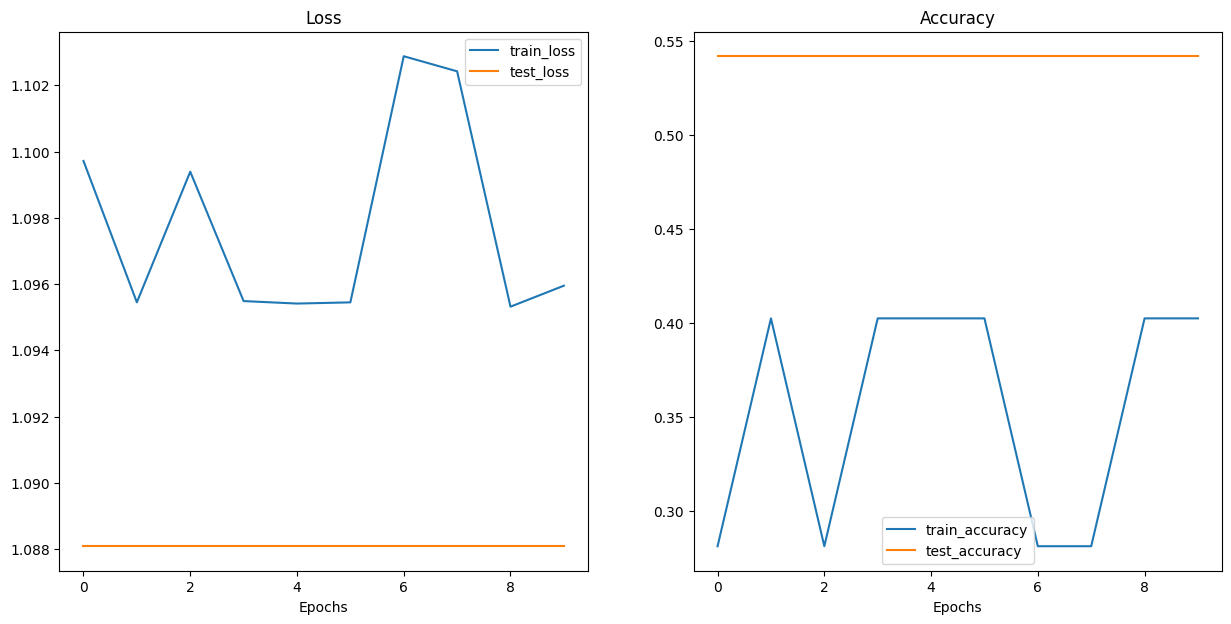

In [72]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like

A Loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1:Tiny VGG qith data augmentation

Now lets try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation


In [75]:
#Create training transform with TrivialAugment

from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `dataset`' and `Dataloader` with Data Augmentation

In [77]:
# Turn imagefolders into Datasets
from torchvision import datasets


train_data_augmented = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform_trivial,
    target_transform = None
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform_simple,
    target_transform = None
)

In [86]:
# Turn datasets into dataloaders

from torch.utils.data import DataLoader

torch.manual_seed(42)
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(
    dataset = train_data_augmented,
    batch_size = BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle = True)


test_dataloader_augmented = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle = False)

### 9.3 Construct and train Model 1:

This time we'll be using the same model architecture except this time we've augmented the training data.

In [87]:
# Create model_1 and sen it totarget device3
torch.manual_seed(42)
model_1 = TinyVGGModel0(
    input_shape=3,
    hidden_units =10,
    output_shape = len(train_data_augmented.classes)).to(device)

model_1


TinyVGGModel0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 9.3.1 Create a loss_fn and an optimizer and call upon the `train()` function

In [94]:

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

#Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr= 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model = model_1,
                epochs = NUM_EPOCHS,
                train_dataloader = train_dataloader_augmented,
                test_dataloader = test_dataloader_simple,
                optimizer = optimizer,
                loss_fn = loss_fn,
                device = device)

# End the timer and prin the time taken
end_time = timer()
time_taken = end_time - start_time
print(f"Time taken: {time_taken:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 0.9464 | Train acc: 0.566406% | Test loss: 0.9969 | Test acc: 0.40%
Epochs: 1 | Train loss: 1.0021 | Train acc: 0.484375% | Test loss: 1.0791 | Test acc: 0.36%
Epochs: 2 | Train loss: 0.8326 | Train acc: 0.605469% | Test loss: 1.0452 | Test acc: 0.33%
Epochs: 3 | Train loss: 0.8714 | Train acc: 0.628906% | Test loss: 1.0431 | Test acc: 0.40%
Epochs: 4 | Train loss: 0.8181 | Train acc: 0.644531% | Test loss: 1.0635 | Test acc: 0.38%
Epochs: 5 | Train loss: 0.8923 | Train acc: 0.617188% | Test loss: 1.0419 | Test acc: 0.42%
Epochs: 6 | Train loss: 0.8281 | Train acc: 0.640625% | Test loss: 0.9684 | Test acc: 0.42%
Epochs: 7 | Train loss: 0.8704 | Train acc: 0.625000% | Test loss: 0.9733 | Test acc: 0.40%
Epochs: 8 | Train loss: 0.9677 | Train acc: 0.476562% | Test loss: 1.0397 | Test acc: 0.40%
Epochs: 9 | Train loss: 0.8653 | Train acc: 0.636719% | Test loss: 0.9245 | Test acc: 0.52%
Time taken: 21.313 seconds


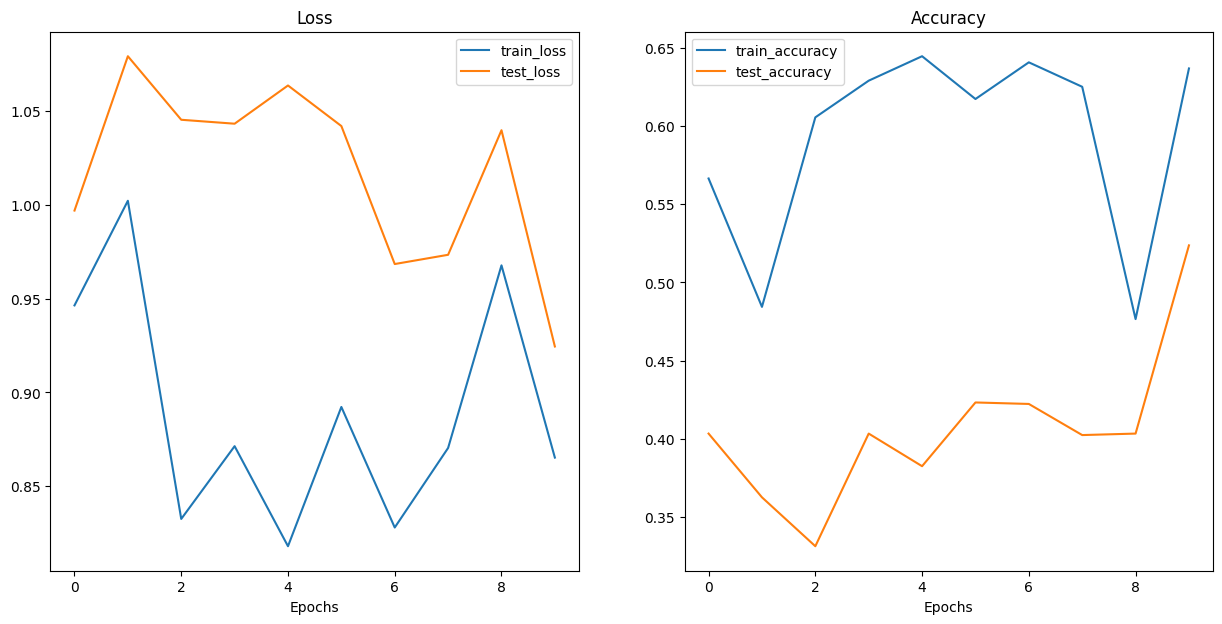

In [95]:
### 9.4 Plot the loss curves of model 1
plot_loss_curves(model_1_results)

## 10 Compare model results

After evaluating our modelling experiments on their own, its important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch +Tensorboard - https://docs.pytorch.org/docs/stable/tensorboard.html
3. Weights and biases = automatically tracking multiple experiments performance - https://wandb.ai/site/experiment-tracking/
4. MLFlow = https://mlflow.org/
                
                

In [97]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)


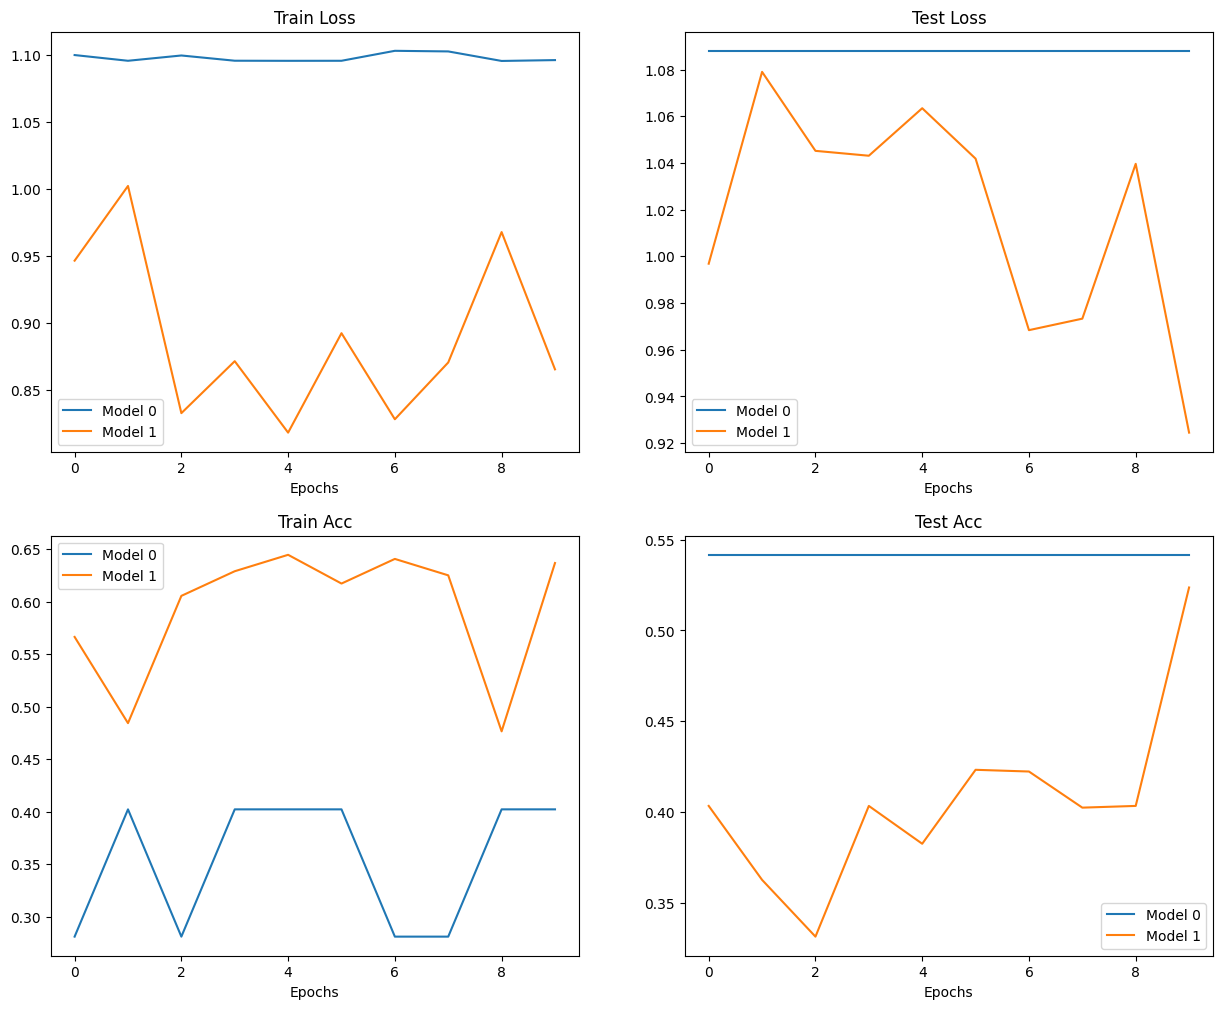

In [105]:
# Setup a plot
plt.figure(figsize=(15,12))

#Get the number of epochs
epochs = range(len(model_0_df))

#Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"], label= 'Model 0')
plt.plot(epochs,model_1_df["train_loss"], label= 'Model 1')
plt.xlabel('Epochs')
plt.title("Train Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"], label= 'Model 0')
plt.plot(epochs,model_1_df["test_loss"], label= 'Model 1')
plt.xlabel('Epochs')
plt.title('Test Loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"], label= 'Model 0')
plt.plot(epochs,model_1_df["train_acc"], label= 'Model 1')
plt.xlabel('Epochs')
plt.title('Train Acc')
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"], label= 'Model 0')
plt.plot(epochs,model_1_df["test_acc"], label= 'Model 1')
plt.xlabel('Epochs')
plt.title('Test Acc')
plt.legend()

## 11. Making a prediction on a custom image

Although we 've trained our model on custom data ... how do you make a prediction on a sample/ image that's not in either training or testing dataset.

In [106]:
# Download a custom image

import requests

#Setup custom image path
custom_image_path = data_path/"04-pizza-uncle.jpg"

#Download the image if it doesnt already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print("Downloading")
    f.write(request.content)
else:
  print("Skipping download ... already exists")



Downloading


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

1. In tensor form with datatype (torch.float32)
2. Of shape 64x64x3
3. On the right device



In [110]:
import torchvision

#Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

In [108]:
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

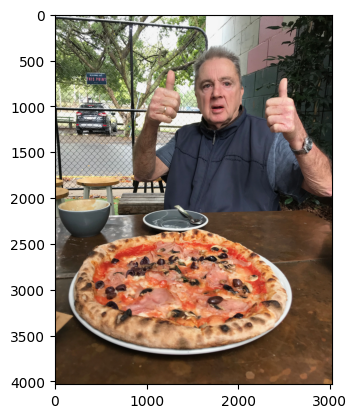

In [109]:
plt.imshow(custom_image_uint8.permute(1,2,0))

##  11.2 Making a prediction on a custom image with a trained PyTorch model


In [122]:
#Load the custom image and change the dtype to float
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)/255
custom_image

# Create transform pipeline to resize the image
from torchvision import transforms
custom_image_transform = transforms.Compose([transforms.Resize(size = (64,64))])

#Transform target image
custom_image_transformed = custom_image_transform(custom_image)

#Print out the shapes
print(f"Original shape {custom_image.shape}")
print(f"Transformed shape {custom_image_transformed.shape}")

Original shape torch.Size([3, 4032, 3024])
Transformed shape torch.Size([3, 64, 64])


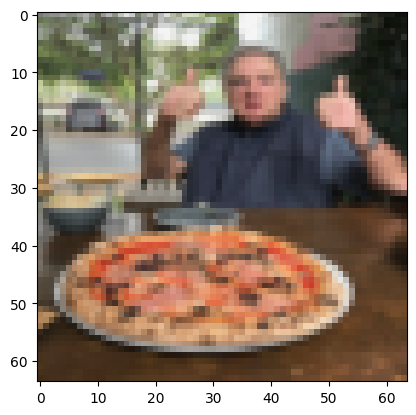

In [125]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [129]:
# Try to make a prediction on an image in uint8 format

# This will error - need to add abatch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.1152, -0.7201, -0.7018]])

In [139]:
pred = torch.argmax(custom_image_pred,dim=1)
pred

tensor([0])

In [138]:
class_names[pred]

'pizza'

Notes to make a prediction on a custom image, we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64,64) with a batch size.... (1,3,64,64)
* Make sure the image was on the same device as our model

In [140]:
# Convert logits to - pred prob -> prediciton labels
custom_image_pred_probs = torch.softmax(custom_image_pred,dim =1)
custom_image_pred_probs

tensor([[0.5332, 0.2313, 0.2355]])

In [141]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs,dim = 1)
custom_image_pred_label

tensor([0])

In [142]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediciton together: building a function
1. Datatype - custom image should be the right datatype
2. Shape - should be the right shape
3. Device - should be on the right device


In [149]:
def custom_image_prediction(model: torch.nn.Module,
                            image_path: str,
                            class_names: List[str],
                            transform = None,
                            device=device):
  """ Makes a prediciton on a target image with a trained model and plot the image and prediction"""

  #Load the image
  target_image = torchvision.io.read_image(image_path).type(torch.float32)

  #Divide the image pixel values by 255 to get them between 0 and 1
  target_image = target_image/255

  #Transform if necessary:
  if transform:
    target_image= transform(target_image)

  # Make sure to put the model on target device
  model = model.to(device)

  #Turn on eval mode
  with torch.inference_mode():
    pred = model(target_image.unsqueeze(0).to(device)) # Adding a batch dimension to target image

  pred_probs = torch.softmax(pred,dim=1)
  pred_label = torch.argmax(pred_probs, dim =1)

  #Plot the image and pred prob and pred
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dim and rearrange dim
  title = f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_probs.max().cpu():.2f}"
  plt.title(title)
  plt.axis(False)



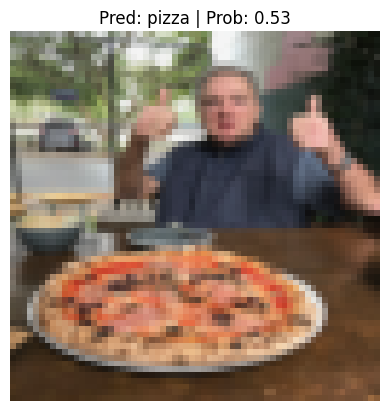

In [155]:
custom_image_prediction(model = model_1,
                        image_path = custom_image_path,
                        class_names = class_names,
                        transform = custom_image_transform,
                        device = device)